In [129]:
#%%capture

import numpy as np
import pandas as pd
import re

# Библиотеки для визуализации
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import plotly.express as px

# Библиотека для работы с кодировщиком
import category_encoders as ce 

# Модуль для автоматического применения статистических тестов 
from scipy import stats

# Анализаторы тональности текстов
!pip install -U nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
!pip install -U Afinn
from afinn import Afinn

# Инструменты для работы с географическими координатами
#from geopy.distance import geodesic
#from geopy.geocoders import Nominatim

# Модуль для шкалирования 
from sklearn import preprocessing

# Функция для оценки значимости непрерывных переменных
from sklearn.feature_selection import f_classif 

# Инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor

# Инструменты для оценки точности модели
from sklearn import metrics 

# Инструмент для разделения датасета
from sklearn.model_selection import train_test_split

# Зафиксируем RANDOM_SEED
RANDOM_SEED = 42

# Зафиксируем версию пакетов
!pip freeze > requirements.txt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/andrey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable


In [130]:
# Подгрузим наши данные из соревнования
#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # Датасет для обучения
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # Датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # Самбмишн

In [131]:
# Подгрузим наши данные
df_train = pd.read_csv('data/hotels_train.csv') # Датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # Датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # Submission

# 1. Знакомство с данными и их предварительный анализ

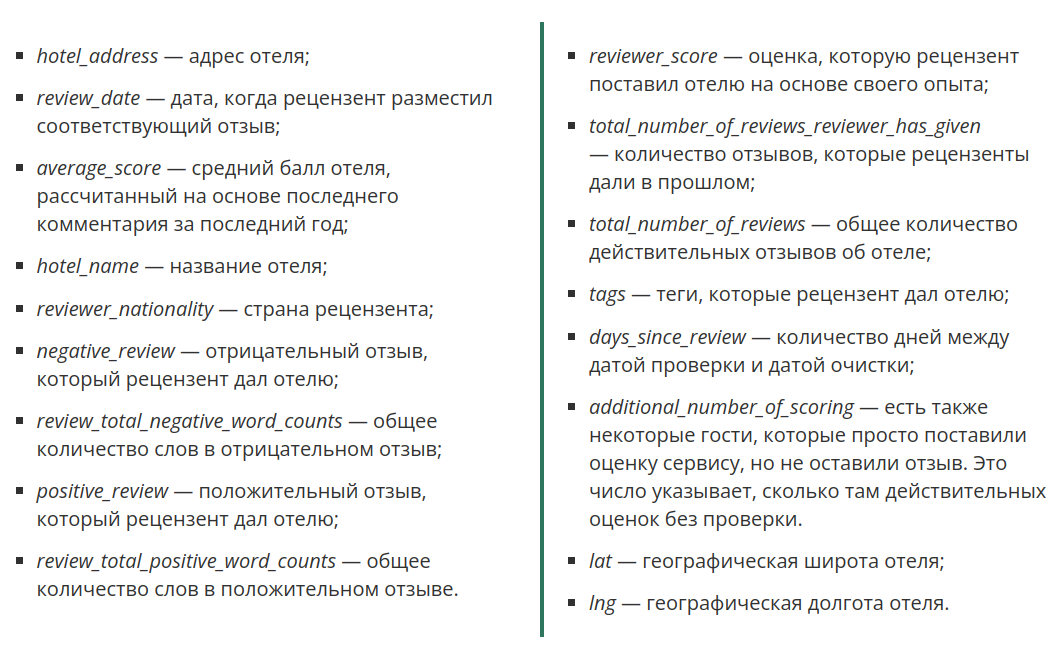

In [132]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [133]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [134]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [135]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [136]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [137]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [138]:
# Для корректной обработки признаков объединяем тренировочный и тестовый в один датасет
df_train['sample'] = 1 # Помечаем тренировочные данные
df_test['sample'] = 0 # Помечаем тестовые данные
df_test['reviewer_score'] = 0 # В тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # Объединяем таблицы

/tmp/ipykernel_8285/2917931526.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [140]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

In [141]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


В явном виде данные пропущены только в столбцах ***lat*** и ***lng***.

# 2. Проектирование признаков



Для удобства работы с признаками создадим списки, в которые будем добавлять признаки соответственно дальнейшим операциями над ними.

In [142]:
# Создадим следующие списки:

# Числовые признаки
numeric_data = data.select_dtypes(include=['int64', 'float64']).copy () 
numeric_data.drop(['sample', 'reviewer_score'], axis=1, inplace=True)
num_cols = list(numeric_data.columns)

# Категориальные признаки для однократного кодирования
cat_cols_one_hot = list()

# Категориальные признаки для двоичного кодирования
cat_cols_binary = list()

# Категориальные признаки для анализа коллинеарности
cat_cols = list()

# Признаки подлежащие удалению
unnecessary_cols = list()

# Признаки для нормализации
norm_cols = list()

Рассмотрим признаки, данные которых представлены не числами.

## 2.1 Hotel_address

Посмотрим на структуру текста признака ***hotel_address***.

Извлечём из этого признака названия стран, городов и индексы.

In [143]:
# Посмотрим на структуру текста
display(data['hotel_address'].value_counts().head(15))

# Создадим признак страны размещения
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1] if x.split(' ')[-1] != 'Kingdom' else ' '.join(x.split(' ')[-2:]))

# Создадим признак города размещения
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2] if x.split(' ')[-2] != 'United' else x.split(' ')[-5])

# Создадим признак индекс отеля
data['hotel_post_index'] = data['hotel_address'].apply(lambda x: x.split(' ')[-3] if x.split(' ')[-1] not in ('Kingdom', 'Netherlands') \
else ' '.join(x.split(' ')[-4:-2]))

# Посмотрим на получившиеся уникальные значения новых признаков и их количествa

print(f"\n{data['hotel_country'].unique()}\n")
print(f"{data['hotel_city'].unique()}\n")
# display(data['hotel_post_index'].unique())
display(data['hotel_post_index'].nunique())

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom              2958
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom                  2768
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                 2628
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom      2565
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                        2551
27 Devonshire Terrace Westminster Borough London W2 3DP United Kingdom            2288
Lakeside Way Brent London HA9 0BU United Ki


['Italy' 'Netherlands' 'Spain' 'United Kingdom' 'France' 'Austria']

['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']



601

В таблице представлены всего 6 стран и в каждой стране всего по 1 городу, поэтому уместно избавиться от признака ***hotel_country***.

Признак ***hotel_city*** является номинальным, имеет всего 6 уникальных значений, поэтому применим к нему однократное кодирование.

Признак ***hotel_post_index*** имеет 601 уникальное значение, также является номинальным, поэтому применим к нему двоичное кодирование.

In [144]:
# Добавим категориальные признаки для однократного кодирования
cat_cols_one_hot.append('hotel_city')

# Категориальные признаки для двоичного кодирования
cat_cols_binary.append('hotel_post_index')

# Добавим имена колонок подлежащих удалению после кодирования
unnecessary_cols.extend(['hotel_address', 'hotel_country', 'hotel_city', 'hotel_post_index'])


___

## 2.2 Review_date

Признак ***review_date*** мне кажется каким-то неинформативным, не вполне передаёт информацию о датах пребывания рецензента в отеле. Можно лишь предполагать, что что отзывы сделаны сразу по прибытии домой, и, таким образом, возможно извлечь информацию сезонного характера, месяц прибывания, а также год, который вероятно будет полезен для понимания динамики изменения рейтинга отеля по годам. Большая детализации, как мне кажется, не нужна. К примеру, мы ни разу не оставляли отзывы об отеле на букинге сразу по возвращении. Если бы наши отзывы попали в эту таблицу, то информация о месяце прибывания была бы неверной.

In [145]:
data['review_date'] = pd.to_datetime(data['review_date'])

# Извлечём из признака месяц
data['review_month'] = data['review_date'].dt.month

# Извлечём из признака год
data['review_years'] = data['review_date'].dt.year

data.sample(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_post_index,review_month,review_years
220232,15 Montague St Bloomsbury Camden London WC1B 5...,196,2016-08-20,9.3,The Montague On The Gardens,Germany,No Negative,0,931,choice of breakfast very friendly hotel service,...,348 day,51.520181,-0.125696,1,10.0,United Kingdom,London,WC1B 5BJ,8,2016
200387,Moll de Barcelona WTC Ciutat Vella 08039 Barce...,666,2016-07-31,8.5,Eurostars Grand Marina Hotel GL,Australia,Slow service at the bar and restaurant,8,4559,Staff and location excellent great and comfor...,...,368 day,41.371308,2.181698,1,9.6,Spain,Barcelona,08039,7,2016
185803,8 10 Queensberry Place Kensington and Chelsea ...,388,2015-12-03,8.4,The Exhibitionist Hotel,United Kingdom,The size of the room for the price of 200 No ...,17,1708,The bed was very comfortable and the staff we...,...,609 day,51.494775,-0.177789,1,7.9,United Kingdom,London,SW7 2EA,12,2015
491072,Passeig Colom 12 Ciutat Vella 08002 Barcelona ...,156,2016-01-30,8.9,Duquesa de Cardona,United Kingdom,The rooms are nice but not amazing value for ...,13,904,Great location and very nice staff,...,551 day,41.379866,2.180527,1,8.8,Spain,Barcelona,08002,1,2016
90060,Viale Andrea Doria 4 Central Station 20124 Mil...,379,2016-08-01,8.9,Starhotels Echo,Italy,Very little bathroom vanity area for personal...,9,3774,Excellent location Modern design Very clean a...,...,367 day,45.484740,9.207292,0,0.0,Italy,Milan,20124,8,2016


Посмотрим, какие месяцы для поездок наиболее популярны. 

Идея с объединением по принципу пик/спад сезона дала худший результат по метрике, поэтому оставляю признак ***review_month*** без изменения

Признак ***review_years*** добавим в список на однократное кодирование.

Добавим признаки ***review_date, review_years*** в список на удаление.

In [146]:
print(f"{data['review_month'].value_counts()}\n")

# Добавим категориальные признаки для однократного кодирования
cat_cols_one_hot.append('review_years')

# Добавим review_month в список категориальных признаков для анализа коллинеарности
cat_cols.append('review_month')

# Добавим имена колонок подлежащих удалению после кодирования
unnecessary_cols.extend(['review_date', 'review_years'])

data.sample(5)

8     50672
7     49318
5     46490
10    43843
6     42896
4     42883
9     42428
1     42151
3     41110
12    39607
2     38370
11    35970
Name: review_month, dtype: int64



,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_post_index,review_month,review_years
332734,30 Rathbone Street West End Westminster Boroug...,199,2015-12-18,8.3,Rathbone,United Kingdom,No fault of the hotel but the surrounding str...,15,776,Executive room worth the little extra friendl...,...,594 day,51.518680,-0.135406,1,8.8,United Kingdom,London,W1T 1LB,12,2015
238868,Excel 2 Festoon Way Royal Victoria Dock Newham...,853,2017-05-08,8.4,DoubleTree By Hilton London Excel,United Kingdom,over rated for a four stars hotel,9,2726,staff overall friendly,...,87 days,51.507377,0.038657,1,5.4,United Kingdom,London,E16 1RH,5,2017
54808,19 21 Gt Marlborough St Westminster Borough Lo...,355,2015-11-29,8.0,Courthouse Hotel London,United Kingdom,No Negative,0,1786,Great location,...,613 day,51.514362,-0.139448,0,0.0,United Kingdom,London,W1F 7HL,11,2015
495053,5 Fairmont Avenue Canary Wharf Tower Hamlets L...,620,2015-10-20,9.0,Radisson Blu Edwardian New Providence Wharf,United Kingdom,Pillows were far too soft Would have preferre...,12,1974,Staff member Clea was amazing Excellent emplo...,...,653 day,51.506558,-0.004514,1,9.2,United Kingdom,London,E14 9JB,10,2015
445099,372 Strand Westminster Borough London WC2R 0JJ...,2288,2016-11-03,8.1,Strand Palace Hotel,United Kingdom,nothing,2,9568,Comfortable quiet cosy single room on 9th flo...,...,273 day,51.511099,-0.120867,1,9.6,United Kingdom,London,WC2R 0JJ,11,2016


---

## 2.3 Hotel_name

Из названия отеля можно было бы извлечь информацию, от том является ли он сетевым. Список сетей отелей превышает количество отелей представленных в таблице. Очень много названий сетей, которые имеют частично одинаковые названия, а также отель может быть несетевым, но в названии могут использоваться слова из именования сети, что исказит общую картину. Т.к. эта работа потребует ручного труда, поэтому пока попробуем обойтись без признака ***hotel_name*** и вернуться к нему позже, если потребуется.

In [147]:
# Добавим hotel_name в список на удаление
unnecessary_cols.append('hotel_name')

---

## 2.4 Reviewer_nationality

Посмотрим на распределение признака ***reviewer_nationality***.

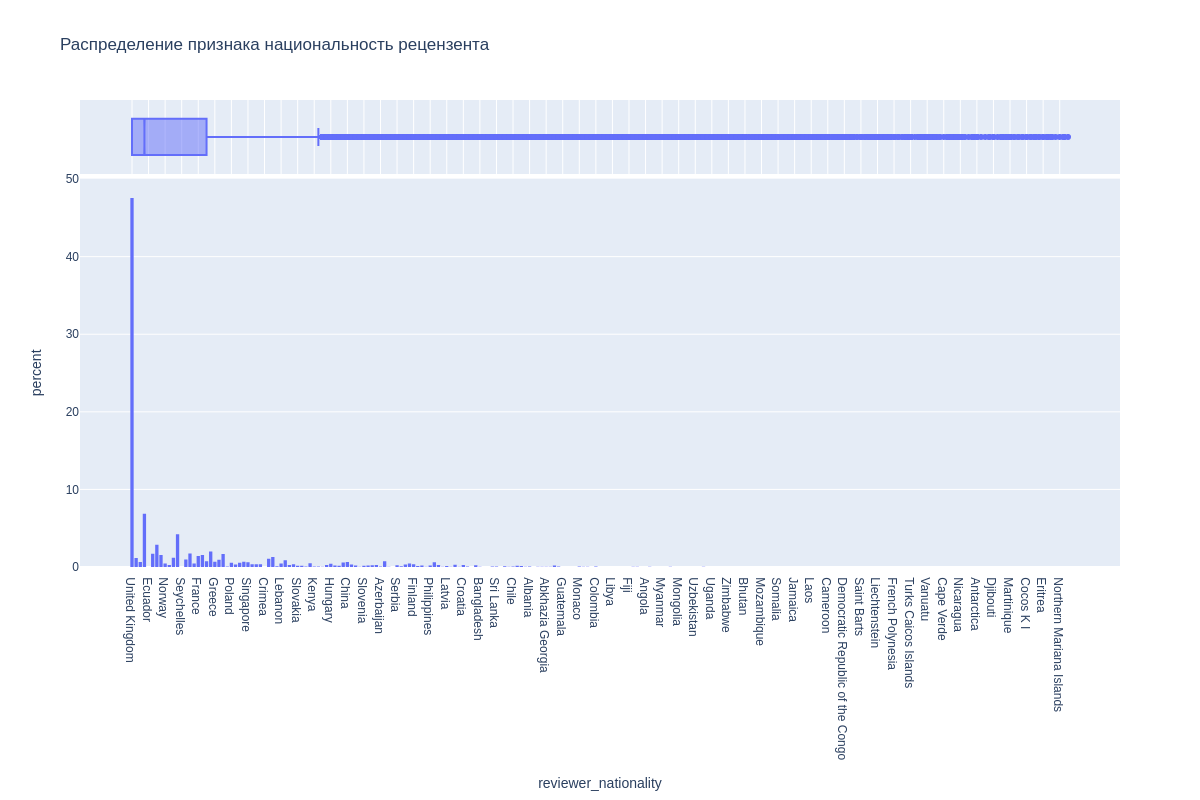

In [148]:
fig = px.histogram(
    data_frame=data,
    x='reviewer_nationality',
    title='Распределение признака национальность рецензента',
    width=1200,
    height=800,
    marginal='box',
    histnorm='percent'
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_1.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Почти 50 процентов посетителей - британцы, представители других государств представлены в таблице в существенно меньшем процентном соотношении. Возможно, это не случайность, и наличие у посетителя гражданства Великобритании может влиять на целевую переменную.

Создадим бинарный признак ***is_uк_nationality*** и добавим признак ***reviewer_nationality*** в список на удаление.

In [149]:
data['is_uк_nationality'] = data['reviewer_nationality'].apply(lambda x: 1 if x == ' United Kingdom ' else 0)

# Добавим is_uк_nationality в список категориальных признаков для анализа коллинеарности
cat_cols.append('is_uк_nationality')

# Добавим reviewer_nationality в список на удаление
unnecessary_cols.append('reviewer_nationality')

data.sample(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lat,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_post_index,review_month,review_years,is_uк_nationality
203388,Van Leijenberghlaan 221 Zuideramstel 1082 GG A...,148,2016-08-04,7.8,NH Amsterdam Zuid,Netherlands,The airco making noise whole night,7,1245,No Positive,...,52.326667,4.880088,1,5.0,Netherlands,Amsterdam,1082 GG,8,2016,0
79825,Hafnersteig 7 01 Innere Stadt 1010 Vienna Austria,78,2016-05-31,8.7,Alma Boutique Hotel,United Kingdom,Breakfast can be much better too basic and av...,17,730,Great location nice staff,...,48.211249,16.377652,0,0.0,Austria,Vienna,1010,5,2016,1
263583,Via Galileo Galilei 2 Central Station 20124 Mi...,207,2017-02-22,8.5,Windsor Hotel Milano,Bulgaria,No Negative,0,2601,We like the hotel room breakfast staff,...,45.479459,9.195143,1,8.8,Italy,Milan,20124,2,2017,0
40810,Moll de Barcelona WTC Ciutat Vella 08039 Barce...,666,2016-05-11,8.5,Eurostars Grand Marina Hotel GL,United Kingdom,Being told at check out that they have got th...,66,4559,Location Gym the bar area was very nice the o...,...,41.371308,2.181698,0,0.0,Spain,Barcelona,08039,5,2016,1
413334,30 Portman Square Westminster Borough London W...,276,2017-01-14,8.7,Hyatt Regency London The Churchill,Cyprus,Breakfast we had to use the corridor as it wa...,21,883,The food was excellent in all respects,...,51.515647,-0.157244,1,9.2,United Kingdom,London,W1H 7BH,1,2017,0


___
## 2.5 Tags

Рассмотрим признак ***tags***.

In [150]:
data['tags'].value_counts().head(20)

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']              5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']       3991
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']             3291
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    3102
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    2947
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']                                                  2906
[' Leisure trip ', ' Cou

Узнаем сколько уникальных значений содержит столбец ***tags***. Извлечём из строковых значений теги и посмотрим в каком количестве они представлены в наборе данных.

In [151]:
# Получим список уникальных тегов
tags_list = data['tags'].unique().tolist()
tags = list()
for item in tags_list:
    new_items = item[1:-1].replace("'", '').split(', ')
    tags.extend(new_items)
un_tags = list(set(tags))
print(f"Число уникальных значений колонки tags - {len(un_tags)}.\n")

# Посчитаем в каком количестве каждый тег присутствует в данных
all_tags_list = data['tags'].tolist()
all_tags = list()
for item in all_tags_list:
    new_items = item[1:-1].replace("'", '').split(', ')
    all_tags.extend(new_items)

from collections import Counter
tags_cnt = sorted(Counter(all_tags).items(), key=lambda x: x[1], reverse=True)
display(tags_cnt[:21])

Число уникальных значений колонки tags - 2428.



[(' Leisure trip ', 417778),
 (' Submitted from a mobile device ', 307640),
 (' Couple ', 252294),
 (' Stayed 1 night ', 193645),
 (' Stayed 2 nights ', 133937),
 (' Solo traveler ', 108545),
 (' Stayed 3 nights ', 95821),
 (' Business trip ', 82939),
 (' Group ', 65392),
 (' Family with young children ', 61015),
 (' Stayed 4 nights ', 47817),
 (' Double Room ', 35207),
 (' Standard Double Room ', 32248),
 (' Superior Double Room ', 31393),
 (' Family with older children ', 26349),
 (' Deluxe Double Room ', 24823),
 (' Double or Twin Room ', 22393),
 (' Stayed 5 nights ', 20845),
 (' Standard Double or Twin Room ', 17483),
 (' Classic Double Room ', 16989),
 (' Superior Double or Twin Room ', 13570)]

Рассмотрим первые двадцать тегов в порядке убывания. Все кроме одного тега можно разделить на четыре группы: "цель поездки", "категория путешественников", "длительность прибывания", "категория номера". Если рассматривать весь список, то преобладают теги, характеризующие категорию номера. Тип номера зависит, в первую очередь, от количества путешественников, и очевидно, что группу туристов, как и семью с детьми, не поселят в двухместный Standard. Поэтому пока выделим из колонки ***tags*** только три признака: ***trip_purpose, travelers_category, duration_of_stay***.

In [152]:
# Создадим признак trip_purpose
def get_trip_purpose(tags):
    if 'Leisure trip' in tags:
        return 'Leisure'
    elif 'Business trip' in tags:
        return 'Business'
    else:
        return np.nan
    
data['trip_purpose'] = data['tags'].apply(get_trip_purpose)

# Создадим признак travelers_category
def get_travelers_category(tags):
    if 'Solo' in tags:
        return 'Solo'
    elif 'Couple' in tags:
        return 'Couple'
    elif 'Family' in tags:
        return 'Family'
    elif 'Group' in tags:
        return 'Group'
    else:
        return np.nan

data['travelers_category'] = data['tags'].apply(get_travelers_category)

# Создадим признак duration_of_stay
regex = '\d{1,}' 
data['duration_of_stay'] = data['tags'].str.findall(regex).str.get(0)

# Посмотрим в каком количестве представлены уникальные признаки
print(f"{data['trip_purpose'].value_counts(dropna=False)} \n")
print(f"{data['travelers_category'].value_counts(dropna=False)} \n")
print(data['duration_of_stay'].value_counts(dropna=False))

Leisure     417778
Business     82939
NaN          15021
Name: trip_purpose, dtype: int64 

Couple    252294
Solo      108545
Family     88442
Group      64346
NaN         2111
Name: travelers_category, dtype: int64 

1      195371
2      143451
3       90818
4       44625
5       19458
6        9142
7        6765
8        2325
9        1193
10        826
11        389
12        288
14        230
13        227
NaN       192
15        126
17         48
16         47
30         43
18         34
19         27
21         23
20         18
22         15
23         10
27         10
28          7
26          7
24          6
25          6
29          5
500         4
35          1
31          1
Name: duration_of_stay, dtype: int64


Заполним пропуски признаков ***trip_purpose, travelers_category*** самым популярным значением. Оба признака номинальные, поэтому применим к ним однократное кодирование.

Пропуски ***duration_of_stay*** также заполним модой. Наиболее популярны первые 7 значений, от 1 до 7 дней пребывания, поэтому обьединим остальные категории в группу со значением 8 (от 8 дней и больше). Добавим этот признак в список к числовым, для дальнейшего анализа распределения перед преобразованием данных.

Посмотрим на итоговое количество уникальных значений этих столбцов.

Добавим ***tags*** в список на удаление.

In [153]:
# Заполним пропуски
data = data.fillna({
    'trip_purpose': data['trip_purpose'].mode()[0],
    'travelers_category': data['travelers_category'].mode()[0],
    'duration_of_stay': data['duration_of_stay'].mode()[0]
})

# Все значения duration_of_stay больше 7 заменим на 8
data['duration_of_stay'] = data['duration_of_stay'].astype(int)
data['duration_of_stay'] = data['duration_of_stay'].apply(lambda x: 8 if x > 7 else x)

print(f"{data['trip_purpose'].value_counts(dropna=False)} \n")
print(f"{data['travelers_category'].value_counts(dropna=False)} \n")
print(data['duration_of_stay'].value_counts(dropna=False))

# Добавим категориальные признаки для однократного кодирования
cat_cols_one_hot.extend(['trip_purpose', 'travelers_category'] )

# Добавим имена колонок подлежащих удалению после кодирования
unnecessary_cols.extend(['tags', 'trip_purpose', 'travelers_category'])

# Добавим duration_of_stay в список категориальных признаков для анализа коллинеарности
cat_cols.append('duration_of_stay')


Leisure     432799
Business     82939
Name: trip_purpose, dtype: int64 

Couple    254405
Solo      108545
Family     88442
Group      64346
Name: travelers_category, dtype: int64 

1    195563
2    143451
3     90818
4     44625
5     19458
6      9142
7      6765
8      5916
Name: duration_of_stay, dtype: int64


---

## 2.6 Negative_review 

Рассмотрим признак ***negative_review***. Признак содержит не только отрицательные отзывы, но и большое количество положительных, например, таких как: *no negative, nothing* (в том числе в составе различных словосочетаний), *n a, none, no complaints, nil* и т.д. 

Перед использованием анализатора заменим эти подстроки на слово с максимально положительной тональностью (+1), *positive*, т.к. иначе Vader воспримет их тональность некорректно. Чтобы не переусердствовать с заменой слов, например, *nothing* встречается и в отрицательном контексте (*the breakfast was nothing to write home about very poor and scanty*), произведём замену только в отзывах определённой длины. Отзывы с явным негативным окрасом, обычно более подробные, имеющие большие длины строк.

In [154]:
display(data['negative_review'].value_counts(dropna=False).head(20))

# Приведём данные столбца к нижнему регистру
data['negative_review'] = data['negative_review'].apply(lambda x: x.lower())

def get_correct_neg_rev(negative_review):
    pos_list = ['no negative', 'nothing', 'no complaints', 'none','all good', 'everything was perfect', 'everything was great']
    pos_list_2 = [' na', ' n a', ' no', ' nil']
    for item in pos_list:
        if item in negative_review and len(negative_review) < 30:
            return 'positive'
    for item in pos_list_2:
        if item in negative_review and len(negative_review) < 6:
            return 'positive'
    return negative_review

# Создадим промежуточный признак        
data['correct_neg_rev'] = data['negative_review'].apply(get_correct_neg_rev)

No Negative         127890
 Nothing             14295
 Nothing              4236
 nothing              2225
 N A                  1037
 None                  984
                       849
 N a                   509
 Breakfast             407
 Small room            373
 Location              368
 Everything            326
 All good              318
 Nothing really        316
 none                  302
 nothing               283
 No complaints         274
 Price                 260
 Nothing really        254
 Nil                   247
Name: negative_review, dtype: int64

Посмотрим на результат.

Количество значений *positive* вполне соответствует суммарному количеству значений группы отзывов с позитивной тональностью

In [155]:
display(data['correct_neg_rev'].value_counts(dropna=False).head(20))

positive                     162218
                                849
 breakfast                      502
 small room                     481
 location                       447
 everything                     374
 price                          302
 small rooms                    245
 room size                      181
 expensive                      165
 staff                          163
 very small room                162
 can t think of anything        140
 leaving                        126
 leaving                        118
 having to leave                110
 can t think of anything        110
 wifi                           108
 expensive breakfast            107
 see above                      105
Name: correct_neg_rev, dtype: int64

---

## 2.7 Positive_review 

Рассмотрим признак ***positive_review***. Признак также содержит не только положительные отзывы, но и отрицательные, например, такие как: *no positive, nothing*

Перед использованием анализатора заменим эти подстроки на слово с максимально отрицательной тональностью -1, *negative*, для их корректной интерпретации.

In [156]:
display(data['positive_review'].value_counts(dropna=False).head(20))

# Приведём данные столбца к нижнему регистру
data['positive_review'] = data['positive_review'].apply(lambda x: x.lower())

def get_correct_pos_rev(positive_review):
    neg_list = ['no positive', 'nothing']
    for item in neg_list:
        if item in positive_review and len(positive_review) < 12:
            return 'negative'
    return positive_review

# Создадим промежуточный признак        
data['correct_pos_rev'] = data['positive_review'].apply(get_correct_pos_rev)

No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
 Location and staff      333
 everything              319
 Good location           276
 Nothing                 225
 Comfy bed               222
Name: positive_review, dtype: int64

Посмотрим на результат.

Количество значений *negative* соответствует суммарному количеству значений группы отзывов с негативной тональностью.

In [157]:
display(data['correct_pos_rev'].value_counts(dropna=False).head(20))

negative               37686
 location              10962
 everything             2629
 the location           1364
 great location         1272
 good location          1195
 location                983
 breakfast               730
 everything              685
 friendly staff          634
 staff                   518
 excellent location      468
 great location          415
 location and staff      412
 location staff          371
 good location           301
 comfy bed               256
 good breakfast          247
 the location            242
 the staff               240
Name: correct_pos_rev, dtype: int64

Применим анализатор Vader и создадим ёще 2 промежуточных признака

In [158]:
# Создадим объекты SentimentIntensityAnalyzer

sent_analyzer_negative = SentimentIntensityAnalyzer()
sent_analyzer_positive = SentimentIntensityAnalyzer()

data['sent_neg_rev'] = data['correct_neg_rev'].apply(lambda x: sent_analyzer_negative.polarity_scores(x))
data['sent_pos_rev'] = data['correct_pos_rev'].apply(lambda x: sent_analyzer_positive.polarity_scores(x))

Создадим новые признаки из столбцов ***sent_neg_rev*** и '***sent_pos_rev*** на основе значений словаря полученного анализатором.

Добавим ненужные названия столбцов в список на удаление.

In [159]:
data['sent_neg_rev_neg'] = data['sent_neg_rev'].apply(lambda x: x['neg'])
data['sent_neg_rev_neu'] = data['sent_neg_rev'].apply(lambda x: x['neu'])
data['sent_neg_rev_pos'] = data['sent_neg_rev'].apply(lambda x: x['pos'])
data['sent_neg_rev_compound'] = data['sent_neg_rev'].apply(lambda x: x['compound'])

data['sent_pos_rev_neg'] = data['sent_pos_rev'].apply(lambda x: x['neg'])
data['sent_pos_rev_neu'] = data['sent_pos_rev'].apply(lambda x: x['neu'])
data['sent_pos_rev_pos'] = data['sent_pos_rev'].apply(lambda x: x['pos'])
data['sent_pos_rev_compound'] = data['sent_pos_rev'].apply(lambda x: x['compound'])

unnecessary_cols.extend(['negative_review', 'positive_review', 'correct_neg_rev', 'correct_pos_rev', 'sent_neg_rev','sent_pos_rev'])
num_cols.extend(['sent_neg_rev_neg', 'sent_neg_rev_neu', 'sent_neg_rev_pos', 'sent_neg_rev_compound', 'sent_pos_rev_neg', 
                 'sent_pos_rev_neu', 'sent_pos_rev_pos', 'sent_pos_rev_compound'])

Попробуем применить к отзывам ещё один анализатор настроений, Afinn. Для этого создадим промежуточный признак ***union_review***, в который объединим все предварительно обработанные отзывы, где отсутствуют неоднозначные слова или словосочетания.

Добавим ***union_review*** в список на удаление, новый признак ***afinn*** в список с числовыми признаками.

In [160]:
# Создадим объект Afinn
afinn = Afinn()
data['union_review'] = data['correct_neg_rev'] + ' ' + data['correct_pos_rev']
data['afinn'] = data['union_review'].apply(lambda x: afinn.score(x))

# Добавим union_review в список на удаление
unnecessary_cols.append('union_review')

# Добавим afinn к числовым признакам
num_cols.append('afinn')

data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,sent_neg_rev_neg,sent_neg_rev_neu,sent_neg_rev_pos,sent_neg_rev_compound,sent_pos_rev_neg,sent_pos_rev_neu,sent_pos_rev_pos,sent_pos_rev_compound,union_review,afinn
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,would have appreciated a shop in the hotel th...,52,16670,hotel was great clean friendly staff free bre...,...,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,would have appreciated a shop in the hotel th...,25.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,no tissue paper box was present at the room,10,5018,no positive,...,0.216,0.784,0.000,-0.2960,1.0,0.000,0.000,-0.5719,no tissue paper box was present at the room n...,-3.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,pillows,3,351,nice welcoming and service,...,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908,pillows nice welcoming and service,3.0
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,no negative,0,1543,everything including the nice upgrade the hot...,...,0.000,0.000,1.000,0.5574,0.0,0.621,0.379,0.9153,positive everything including the nice upgrad...,11.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,no negative,0,4687,lovely hotel v welcoming staff,...,0.000,0.000,1.000,0.5574,0.0,0.230,0.770,0.7717,positive lovely hotel v welcoming staff,5.0


---

## 2.8 Days_since_review

Признак ***days_since_review***, как мне кажется, не несёт никакой полезной информации, скорее относится к внутренней кухне работы Букинга. Поэтому внесём его в список на удаление.

---

## 2.9 Lat, Lng

Признаки ***lat***, ***lng***, географические широта и долгота отеля, содержат информацию о местоположении отеля, как и признаки индекса, но с большей точностью. А также ***lat*** и ***lng*** имеют пропуски. Возможно будет достаточно просто индекса, который объёдиняет отели по территориальному принципу внутри города. Поэтому пока добавим эти 2 признака в список на удаление, при необходимости вернёмся к этим признакам позже, например, чтобы посчитать расстояние до центра города, как фактор влияющий на выбор отеля туристом. (Была попытка сделать это на Каггле посредством geopy, но возникали ошибки соединения и технического характера, поэтому пока отложила работу с этими признаками, учитывая, что они не играют ключевую роль для предсказания).

In [161]:
# Добавим имена колонок подлежащих удалению
unnecessary_cols.extend(['days_since_review','lat', 'lng'])

# Удалим lat, lng из списка с числовыми признаками
num_cols.remove('lat')
num_cols.remove('lng')

### Кодирование признаков

In [162]:
# Применим однократное кодирование к признакaм из списка для кодирования
encoder = ce.OneHotEncoder(cols=cat_cols_one_hot, use_cat_names=True)
type_bin_one_hot = encoder.fit_transform(data[cat_cols_one_hot])
data = pd.concat([data, type_bin_one_hot], axis=1)

# Применим двоичное кодирование к признакам из соответствующего списка
bin_encoder = ce.BinaryEncoder(cols=cat_cols_binary)
type_bin_binary = bin_encoder.fit_transform(data[cat_cols_binary])
data = pd.concat([data, type_bin_binary], axis=1)

# Добавим новые признаки в список категориальных для анализа коллинеарности
cat_cols.extend(list(type_bin_one_hot.columns))
cat_cols.extend(list(type_bin_binary.columns))

# 3. Преобразование признаков

Посмотрим на описательные статистики и распределение числовых признаков из списка num_cols.



,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,review_month,duration_of_stay
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.486660,2.288457
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.351779,1.477241
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,1.000000,1.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,4.000000,1.000000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.000000,2.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.000000,3.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,12.000000,8.000000


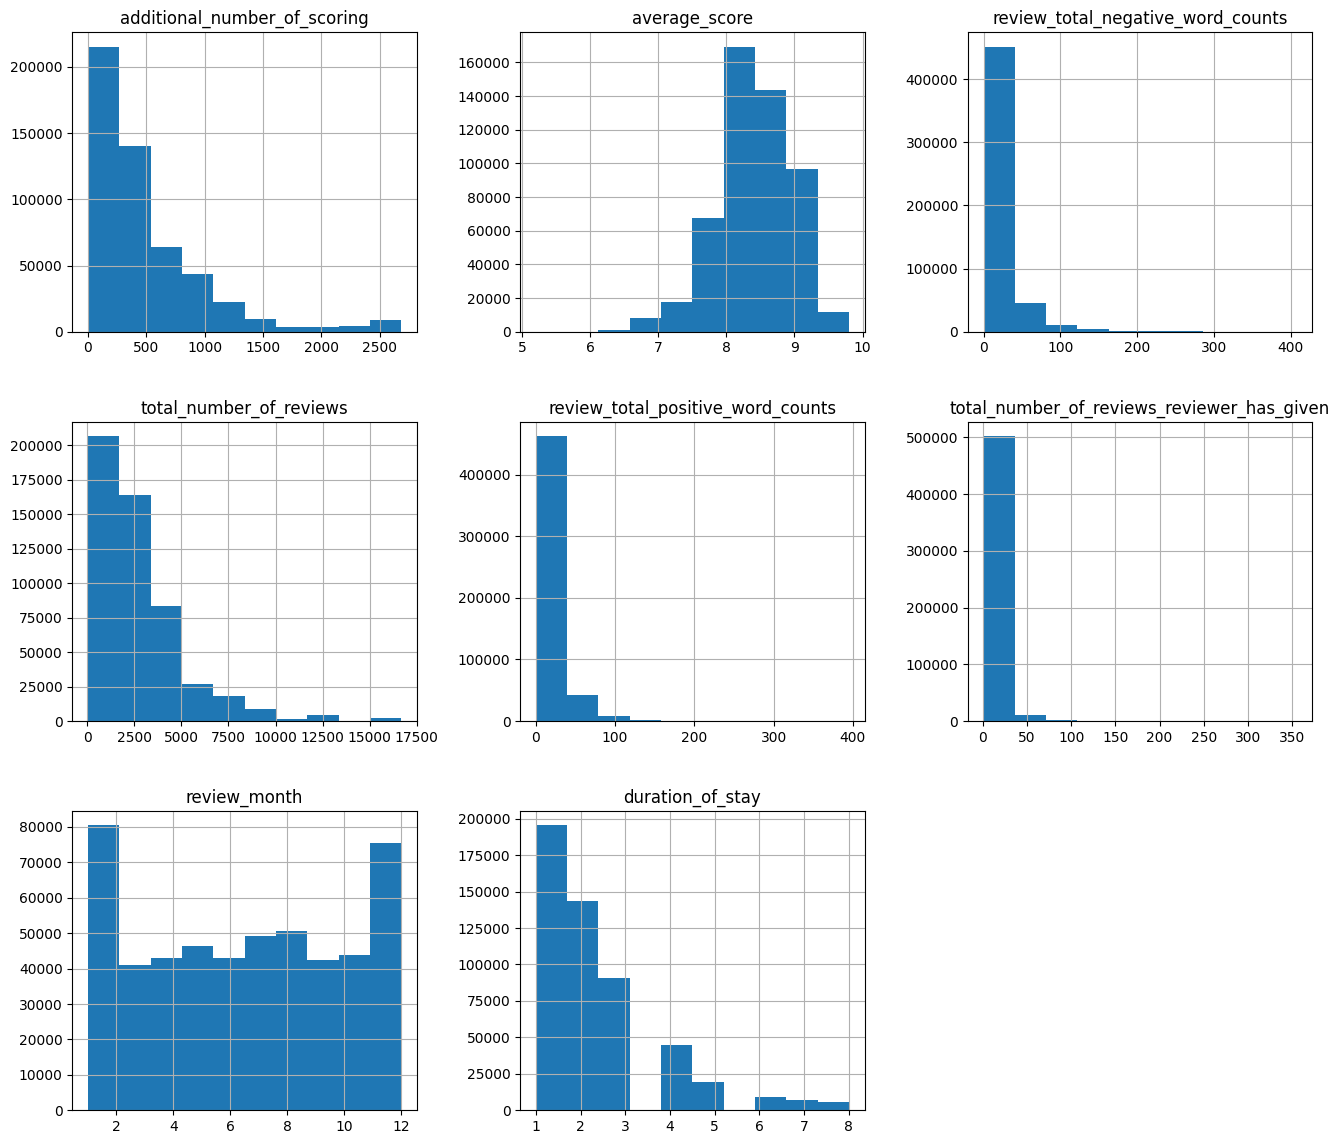

In [163]:
# Построим распределение числовых признаков, а также 2-х категориальных, которые необходимо шкалировать
hist_cols = num_cols[:6].copy() # Исключим признаки тональности отзывов
hist_cols.extend(['review_month', 'duration_of_stay'])
data[hist_cols].hist(figsize=(16,14));

# Посмотрим на описательные статистики
display(data[hist_cols].describe())

Все признаки кроме ***average_score*** имеют ненормальное распределение. Работа с выбросами на этих признаках не производилась, поэтому применим к этим столбцам нормализатор RobustScaler. 

Признак ***average_score*** рассмотрим детальнее.

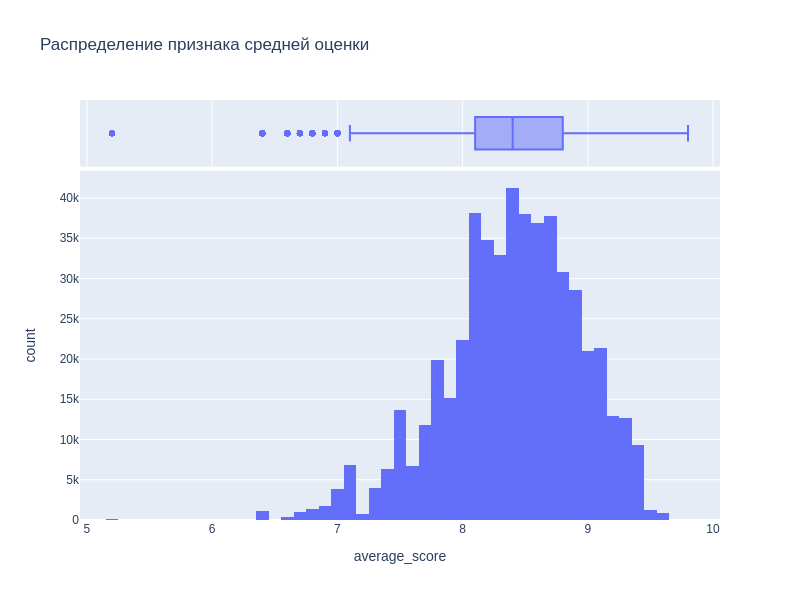

In [164]:
fig = px.histogram(
    data_frame=data,
    x='average_score',
    title='Распределение признака средней оценки',
    width=800,
    height=600,
    marginal='box'
)
# Сохраним диаграмму в формате html в папке plotly
fig.write_html('plotly/img_2.html')

# Отобразим диаграмму в формате png для корректного отображения на githab
fig.show('png')

#fig.show()

Распределение признака ***average_score*** немного похоже на нормальное, но имеет левосторонюю ассиметрию, а также присутствуют выбросы. Построим график q-q plot для большей наглядности. 

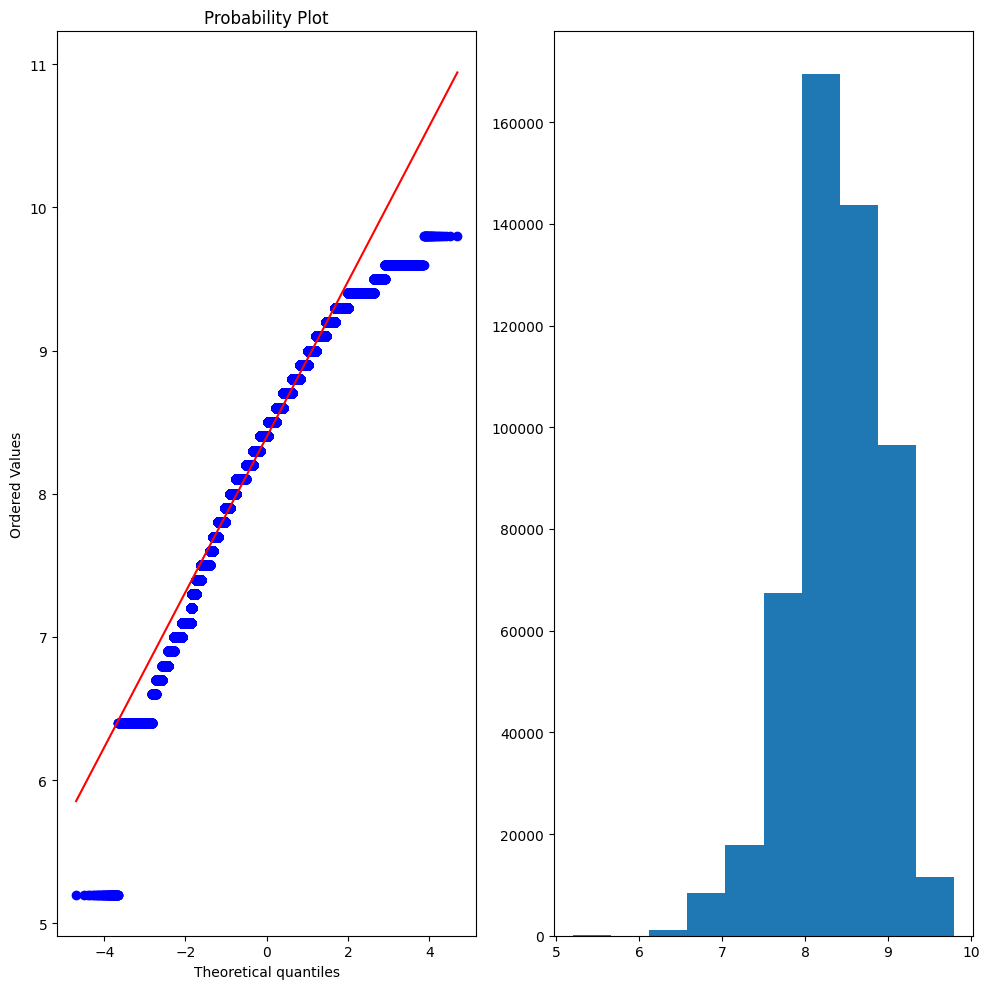

In [165]:
plt.subplot(1, 2, 1) # Зададим сетку рисунка
stats.probplot(data['average_score'], plot=plt) # qq plot

plt.subplot(1, 2, 2) # Расположим гистограмму распределения признака рядом
plt.hist(data['average_score'])

plt.tight_layout()
plt.show()

Похоже, что признак распределен ненормально, так как q-q plot имеет изгиб. Попробуем также применить к признаку ***average_score*** нормализацию посредством класса RobustScaler.

In [166]:
# Инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

norm_cols.extend(hist_cols)

#Кодируем исходный датасет
data_r = r_scaler.fit_transform(data[norm_cols])

data_r = pd.DataFrame(data_r, columns=norm_cols)

for column in norm_cols:
    data[column] = data_r[column]
    
# Посмотрим как изменились описательные статистики
display(data[norm_cols].describe())
display(data.head())


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,review_month,duration_of_stay
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.319922,-0.003590,0.454260,0.248672,0.398615,0.595143,-0.102668,0.144228
std,1.019427,0.782926,1.413849,0.945132,1.282599,1.577175,0.670356,0.738621
min,-0.692464,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714,-1.200000,-0.500000
25%,-0.350305,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714,-0.600000,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.649695,0.571429,0.666667,0.603181,0.647059,0.714286,0.400000,0.500000
max,4.767821,2.000000,19.000000,5.928222,22.588235,50.285714,1.000000,3.000000


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,hotel_post_index_0,hotel_post_index_1,hotel_post_index_2,hotel_post_index_3,hotel_post_index_4,hotel_post_index_5,hotel_post_index_6,hotel_post_index_7,hotel_post_index_8,hotel_post_index_9
0,Via Senigallia 6 20161 Milan Italy,1.146640,2017-07-21,-0.428571,Hotel Da Vinci,United Kingdom,would have appreciated a shop in the hotel th...,2.047619,5.928222,hotel was great clean friendly staff free bre...,...,0,0,0,0,0,0,0,0,0,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,0.551935,2016-12-12,0.285714,Urban Lodge Hotel,Belgium,no tissue paper box was present at the room,0.047619,1.176183,no positive,...,0,0,0,0,0,0,0,0,1,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,-0.600815,2015-11-26,-0.142857,Alexandra Barcelona A DoubleTree by Hilton,Sweden,pillows,-0.285714,-0.727162,nice welcoming and service,...,0,0,0,0,0,0,0,0,1,1
3,Piazza Della Repubblica 17 Central Station 201...,-0.203666,2015-10-17,1.000000,Hotel Principe Di Savoia,United States of America,no negative,-0.428571,-0.241028,everything including the nice upgrade the hot...,...,0,0,0,0,0,0,0,1,0,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,1.004073,2016-05-16,1.000000,Hotel Esther a,United Kingdom,no negative,-0.428571,1.041191,lovely hotel v welcoming staff,...,0,0,0,0,0,0,0,1,0,1


# 4. Oтбор признаков

Cоздадим копию таблицы.

In [167]:
data_copy = data.copy()

Удалим ненужные столбцы

In [168]:
data_copy = data_copy.drop(unnecessary_cols, axis=1)

In [169]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  float64
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  float64
 3   total_number_of_reviews                     515738 non-null  float64
 4   review_total_positive_word_counts           515738 non-null  float64
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   review_month                                515738 non-null  float64
 9   is_uк_nationality                           515738 non-null  int64  
 

## 4.1 Анализ мультиколлиниарности


### 4.1.1 Анализ мультиколлиниарности числовых признаков

Числовые переменные распределены ненормально, поэтому используем для вычисления взаимосвязей коэффициент корреляции Спирмена

Text(0.5, 1.0, 'Тепловая матрица корреляций числовых признаков\n')

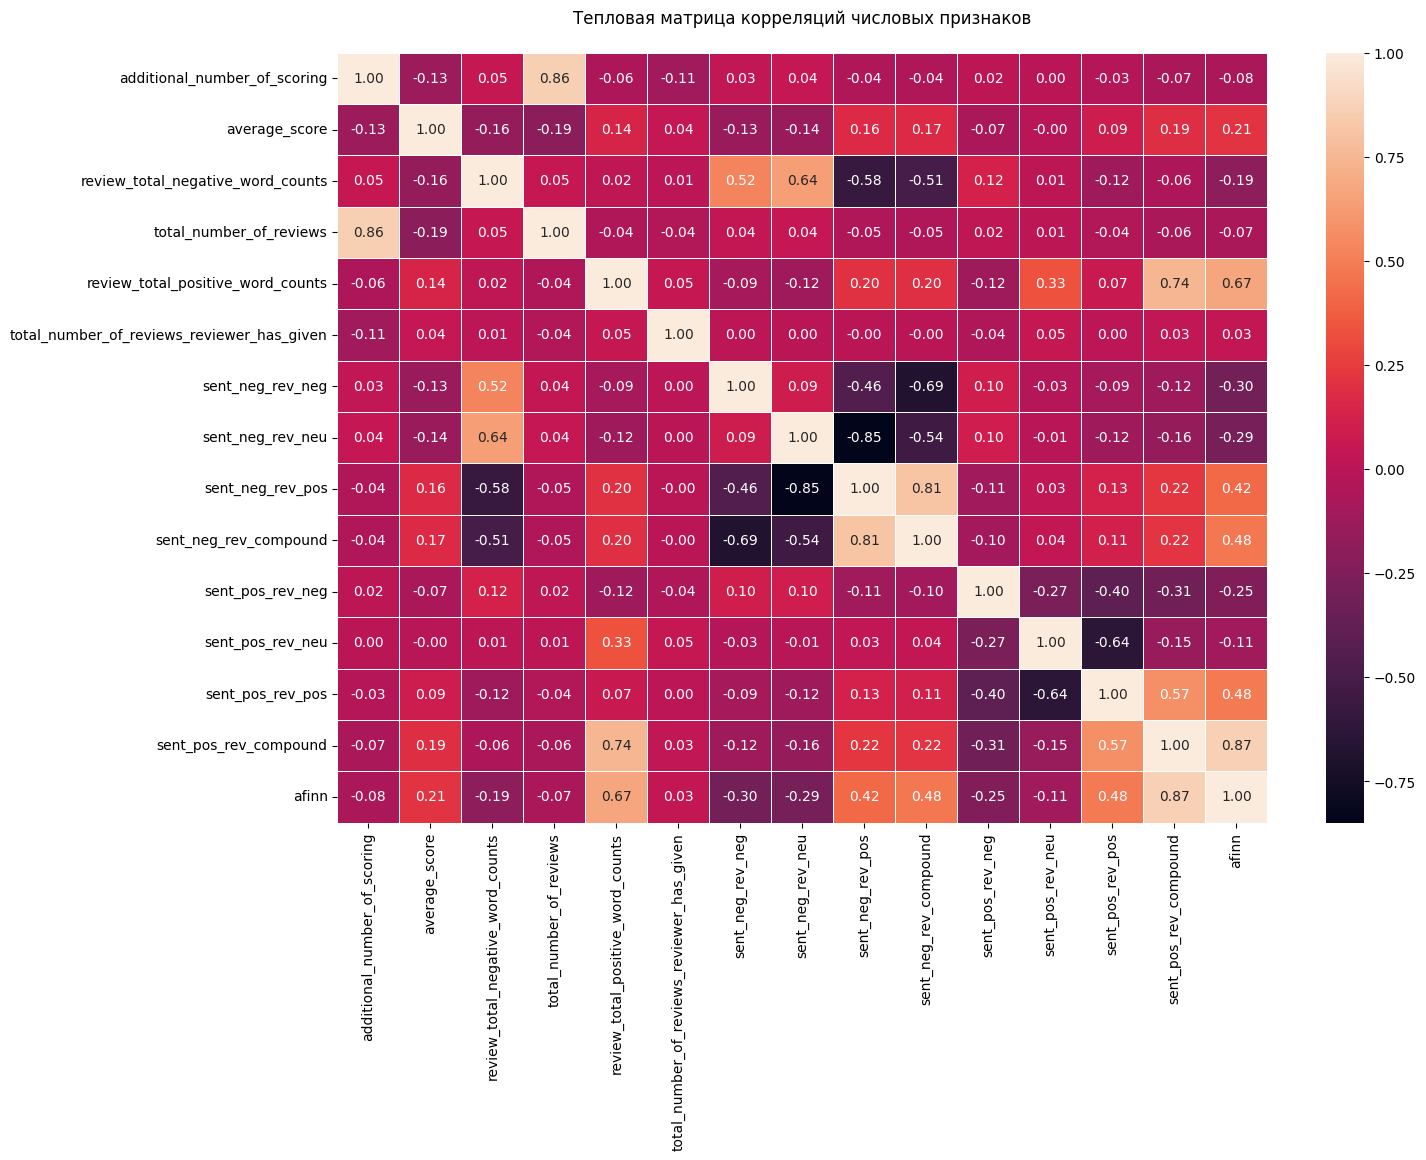

In [170]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data[num_cols].corr(method='spearman'), annot=True, linewidths=.5, ax=ax, fmt='.2f')
ax.set_title('Тепловая матрица корреляций числовых признаков\n')

Удалим только один признак из всех пар с корреляцией выше 0,7, т.к. удаление двух других ухудшает метрику.

In [171]:
data_copy.drop('additional_number_of_scoring', axis=1 , inplace=True )


### 4.1.2 Анализ мультиколлиниарности категориальных признаков

Text(0.5, 1.0, 'Тепловая матрица корреляций категориальных признаков\n')

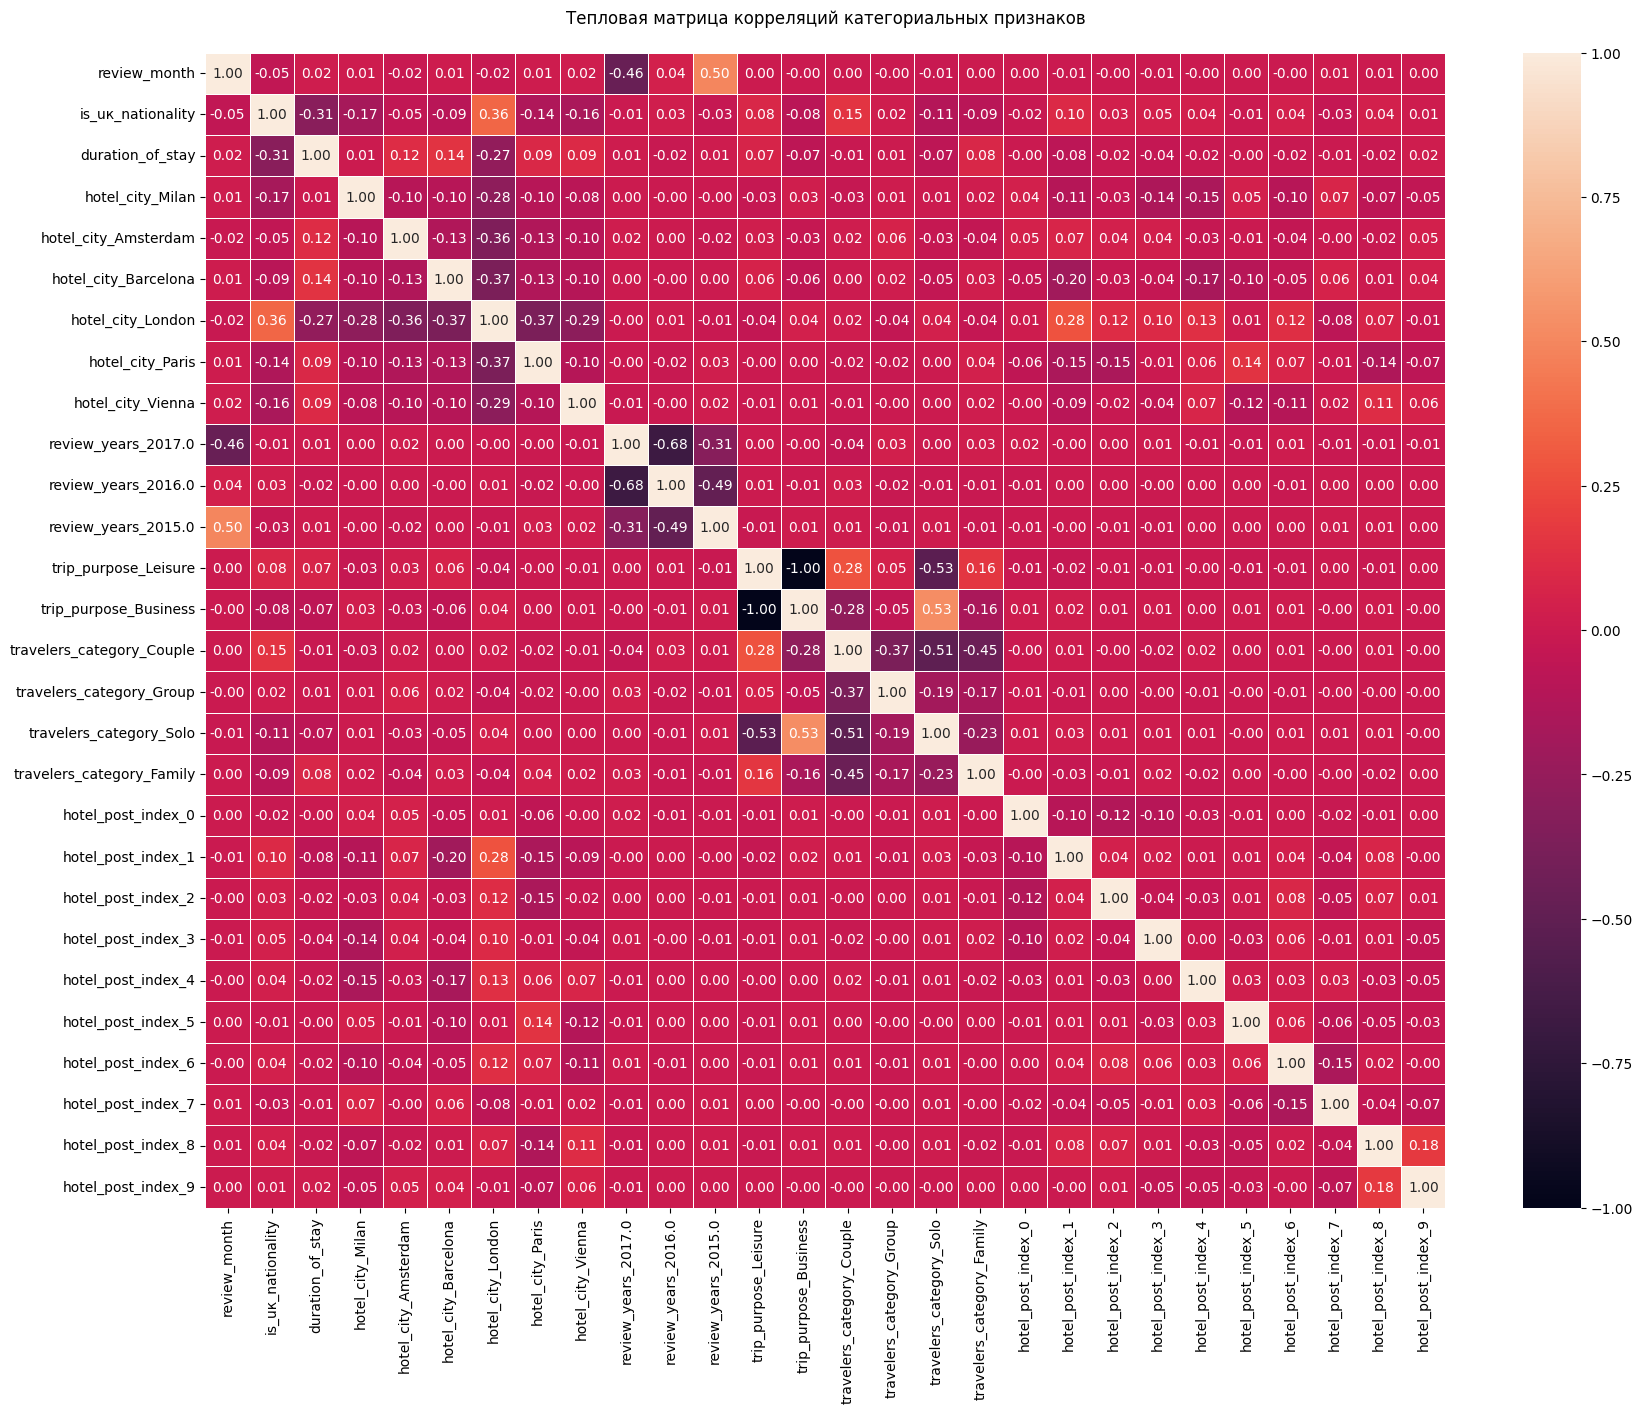

In [172]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(data[cat_cols].corr(method='spearman'), annot=True, linewidths=.5, ax=ax, fmt='.2f')
ax.set_title('Тепловая матрица корреляций категориальных признаков\n')

## 4.2 Оценка значимости признаков

Проведем оценку значимости признаков. Наша зависимая переменная (целевой признак) - количественная. Для оценки значимости воспользуемся функцией f_classif из библиотеки sklearn.

In [173]:
# Теперь выделим тестовую часть
train_data = data_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = data_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

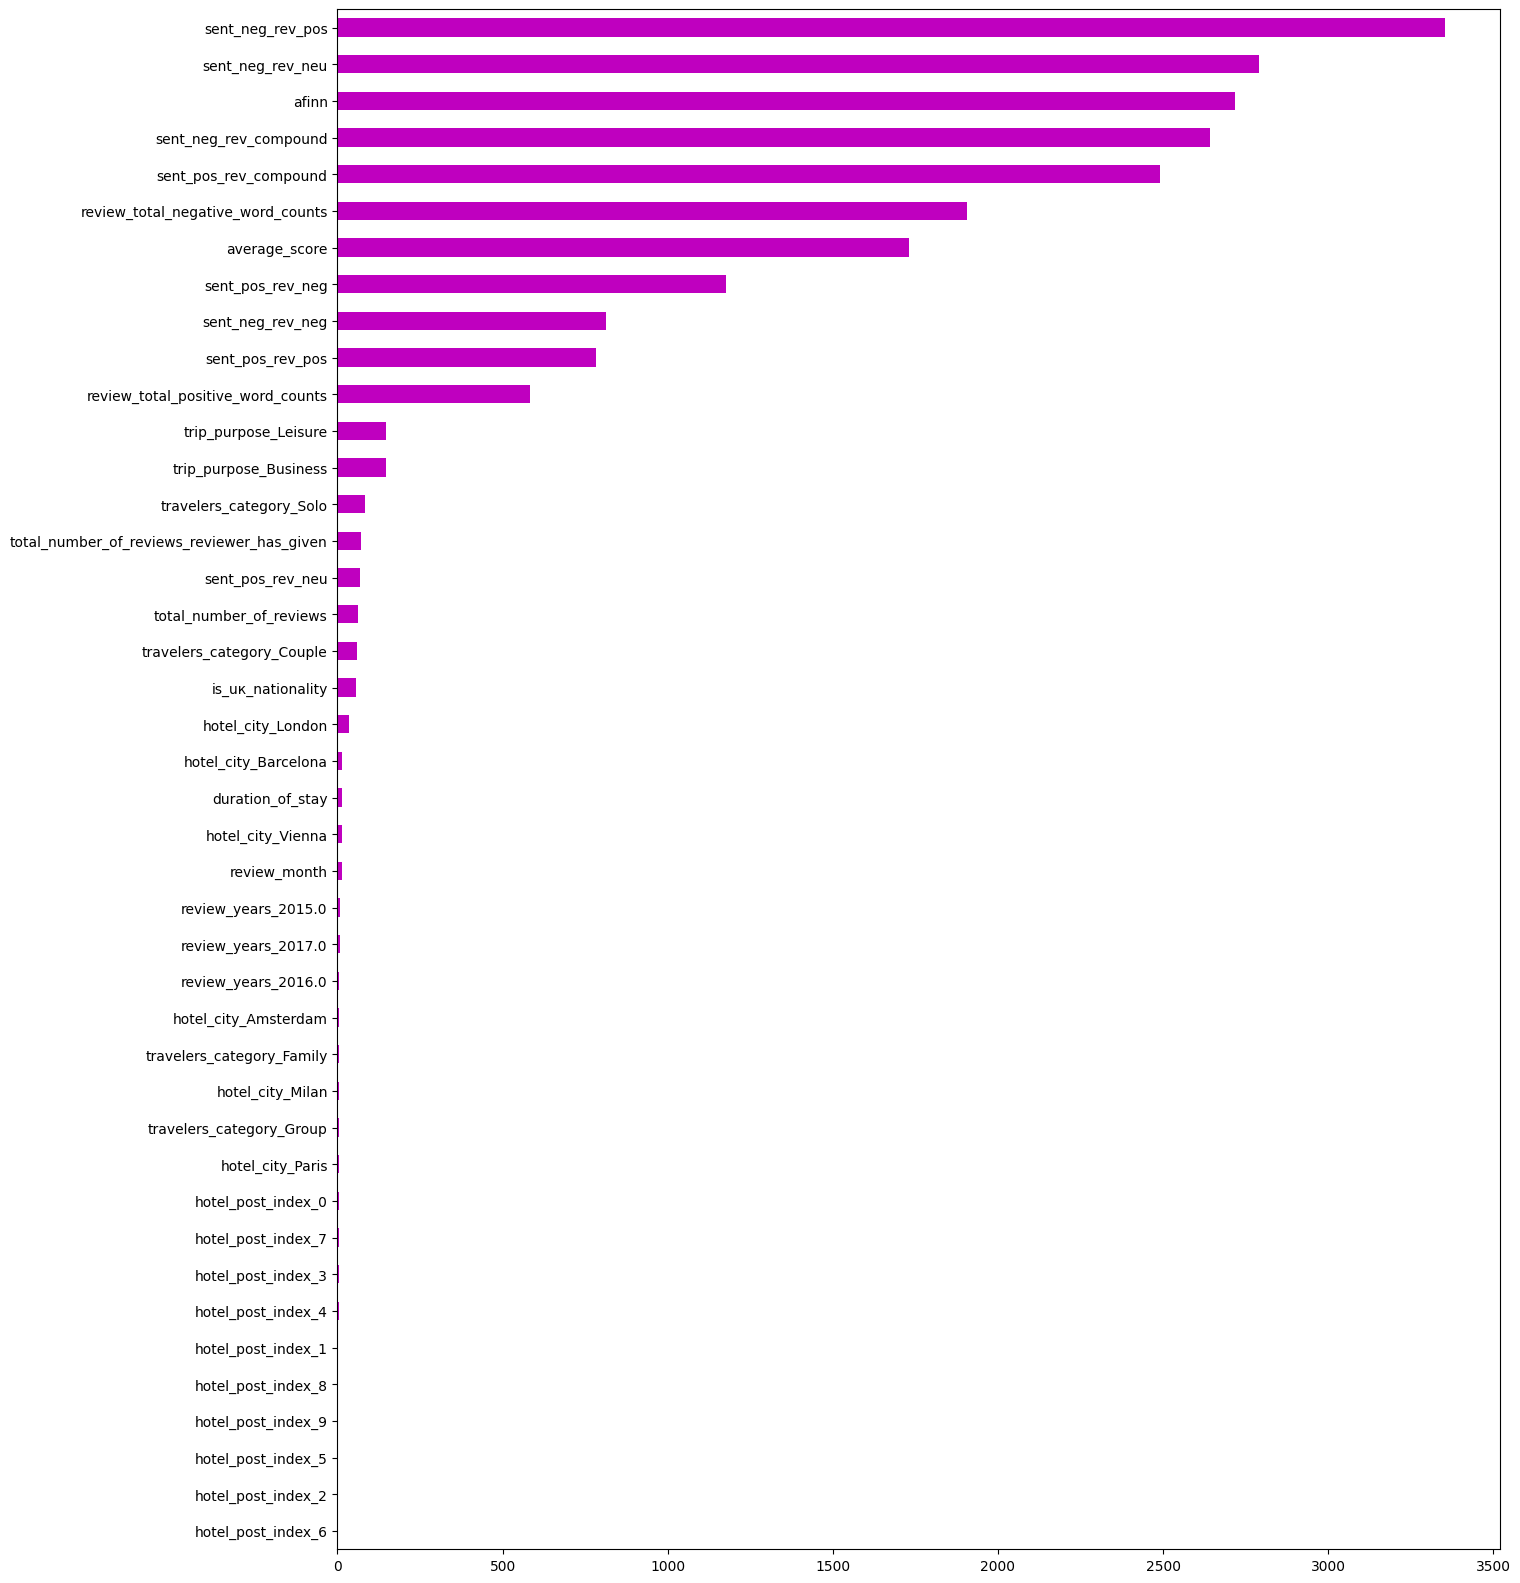

In [174]:
# Визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='m');

Удалим все признаки, у которых отсутствует корреляция с зависимой переменной.

In [175]:
drop_columns = ['hotel_post_index_0', 'hotel_post_index_1', 'hotel_post_index_2','hotel_post_index_3', 
                'hotel_post_index_4', 'hotel_post_index_5', 'hotel_post_index_6', 'hotel_post_index_7', 
                'hotel_post_index_8', 'hotel_post_index_9', 'hotel_city_Milan', 'hotel_city_Paris', 
                'travelers_category_Group', 'travelers_category_Family',]

# Удалим незначимые данные:
data_copy.drop(drop_columns, axis = 1, inplace=True)

In [176]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  float64
 2   total_number_of_reviews                     515738 non-null  float64
 3   review_total_positive_word_counts           515738 non-null  float64
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   review_month                                515738 non-null  float64
 8   is_uк_nationality                           515738 non-null  int64  
 9   duration_of_stay                            515738 non-null  float64
 

# 5. Обучение модели

In [177]:
# Теперь выделим тестовую часть
train_data = data_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = data_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values  # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [178]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [179]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 29), (386803, 29), (386803, 28), (309442, 28), (77361, 28))

In [180]:
X_train.columns

Index(['average_score', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'review_month',
       'is_uк_nationality', 'duration_of_stay', 'sent_neg_rev_neg',
       'sent_neg_rev_neu', 'sent_neg_rev_pos', 'sent_neg_rev_compound',
       'sent_pos_rev_neg', 'sent_pos_rev_neu', 'sent_pos_rev_pos',
       'sent_pos_rev_compound', 'afinn', 'hotel_city_Amsterdam',
       'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Vienna',
       'review_years_2017.0', 'review_years_2016.0', 'review_years_2015.0',
       'trip_purpose_Leisure', 'trip_purpose_Business',
       'travelers_category_Couple', 'travelers_category_Solo'],
      dtype='object')

In [181]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

## 5.1 Обучение модели и предсказание 

In [182]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
Метрика - Mean Absolute Error (MAE) (среднее отклонение предсказанных значений от фактических).

In [183]:
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.31


Оценим значимость признаков в определении рейтинга отеля

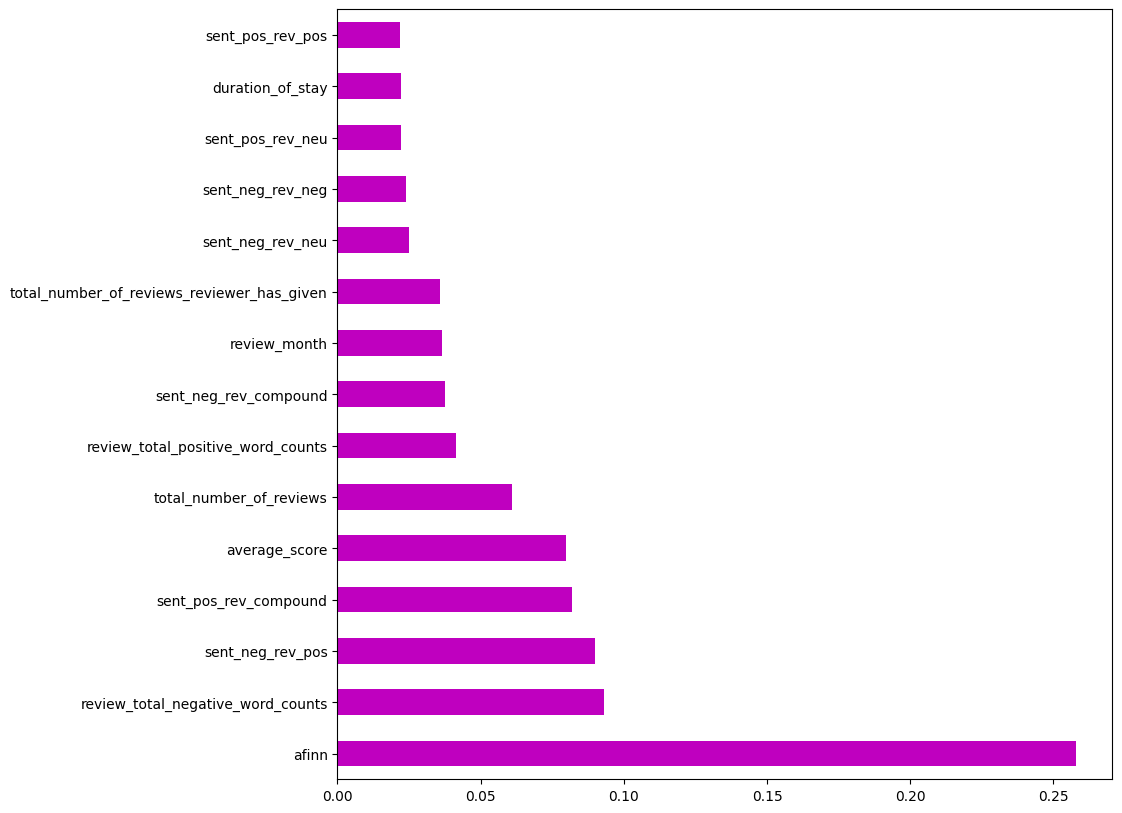

In [184]:
# в RandomForestRegressor есть возможность вывести самые важные признаки
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='m');

In [185]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,review_month,is_uк_nationality,duration_of_stay,sent_neg_rev_neg,...,hotel_city_Barcelona,hotel_city_London,hotel_city_Vienna,review_years_2017.0,review_years_2016.0,review_years_2015.0,trip_purpose_Leisure,trip_purpose_Business,travelers_category_Couple,travelers_category_Solo
72426,0.714286,-0.428571,-0.311990,-0.058824,-0.142857,0.0,-0.8,0,1.0,0.0,...,0,0,0,0,1,0,0,1,0,1
49938,-0.142857,-0.047619,0.282219,0.000000,0.285714,0.0,-1.2,0,1.5,0.0,...,0,1,0,0,1,0,0,1,0,1
111156,1.000000,-0.142857,-0.394780,-0.470588,5.142857,0.0,1.0,1,0.5,0.0,...,0,1,0,0,0,1,0,1,1,0
98489,-0.571429,0.333333,-0.568923,0.352941,1.857143,0.0,1.0,0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,1
31698,0.285714,-0.333333,-0.784666,-0.529412,0.571429,0.0,-1.2,1,-0.5,0.0,...,0,1,0,1,0,0,1,0,0,0
31663,1.142857,0.476190,-0.646411,-0.058824,-0.285714,0.0,0.2,1,-0.5,0.0,...,0,0,0,0,0,1,1,0,1,0
112256,0.428571,-0.428571,-0.604405,-0.235294,5.714286,0.0,0.0,0,-0.5,0.0,...,0,0,0,0,1,0,0,1,1,0
14940,-0.285714,0.000000,0.351142,-0.352941,-0.285714,0.0,-0.8,1,-0.5,0.0,...,0,1,0,1,0,0,1,0,1,0
88552,0.428571,-0.047619,1.265090,-0.235294,0.142857,0.0,-0.6,0,0.5,0.0,...,0,0,0,1,0,0,1,0,1,0
57232,0.857143,0.523810,-0.380914,2.705882,-0.285714,0.0,0.0,1,-0.5,0.0,...,0,1,0,0,1,0,1,0,1,0


### 5.2 Предсказание целевой переменной

In [186]:
test_data = test_data.drop(['reviewer_score'], axis=1)

# Получим предсказание целевой переменной
predict_submission = model.predict(test_data)

# Сохраним полученный результат
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.7s finished


,reviewer_score,id
0,8.501,488440
1,7.214,274649
2,7.637,374688
3,9.718,404352
4,9.479,451596
5,8.730,302161
6,8.022,317079
7,7.772,13963
8,8.455,159785
9,7.503,195089


Наиболее важными из всех признаков влияющих на целевую переменную, стали спроектированные признаки тональности текста и исходные, такие, как рейтинг отеля и непрерывные признаки, связанные с отзывами. Немного улучшить метрику мне удалось при помощи анализатора Afinn, но из-за конфликта версий мне не удалось это решение отправить на соревнование на Каггле. Работа с координатами посредством geopy из-за ошибок мною не была закончена, поэтому не получилось проверить влияние этого признака на предсказание рейтинга. Нормализация улучшила метрику всего лишь менее, чем на одну тысячную.